[*********************100%%**********************]  1 of 1 completed
12/12 [==============================] - 1s 28ms/step
RMSE: 5.812963736215446
MAE: 1.1937201023101807
MAPE: 0.02227122408220293
Coefficient de corrélation de Pearson: 0.9476143513001488


<ipython-input-28-791a8e921f8e>:82: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid_df['Predictions'] = np.nan  # Initialiser toutes les valeurs à NaN


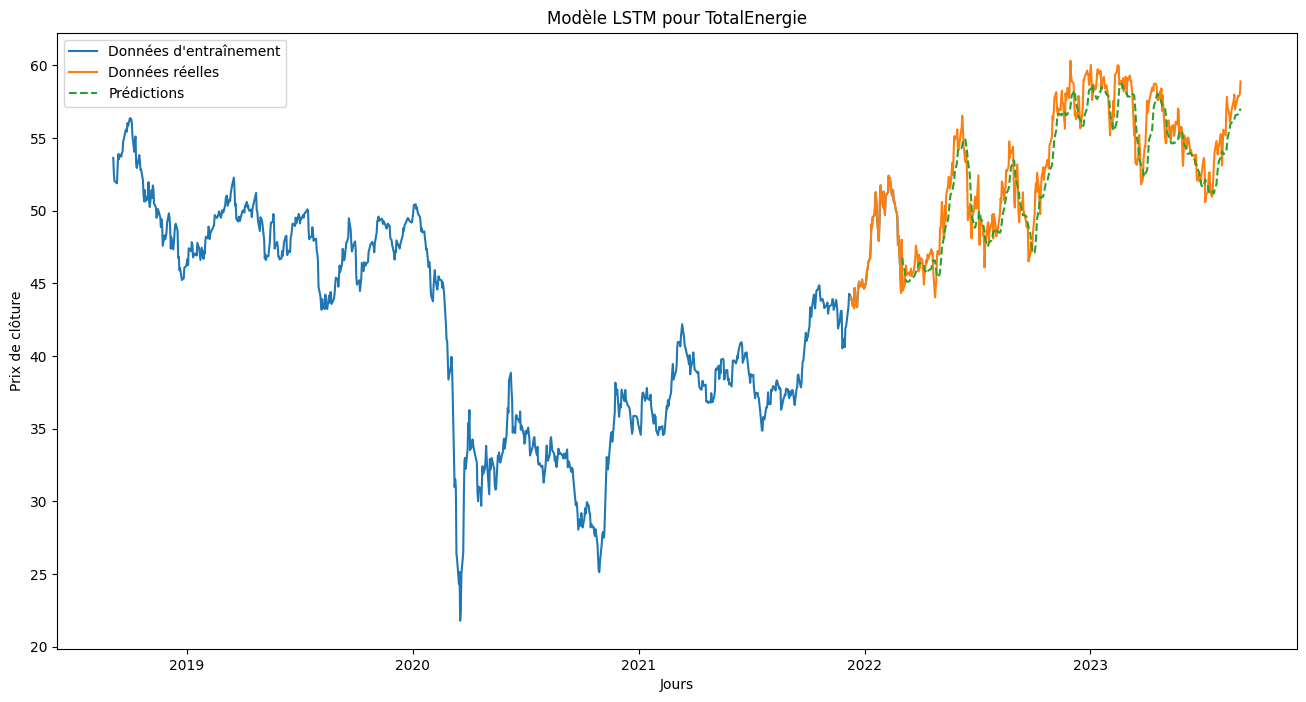

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import yfinance as yf
import math
from keras.models import Sequential
from keras.layers import Dense, LSTM
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error
import scipy.stats

# Télécharger les données de TotalEnergie depuis Yahoo Finance pour les 5 dernières années
stock_data = yf.download('TTE.PA', start='2018-09-04', end='2023-09-04')

# 1. Filtrer les données de clôture du marché
close_data = stock_data['Close']

# 2. Convertir les données en tableau pour une évaluation aisée
dataset = close_data.values

# 3. Mettre à l'échelle/normaliser les données pour avoir des valeurs entre 0 et 1
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(dataset.reshape(-1, 1))

# 4. Créer la taille des données d'entraînement : 70 % des données
training_data_len = math.ceil(len(dataset) * 0.7)
train_data = scaled_data[0:training_data_len, :]

# 5. Séparer les données en données x et y
x_train_data = []
y_train_data = []
for i in range(60, len(train_data)):
    x_train_data.append(train_data[i-60:i, 0])
    y_train_data.append(train_data[i, 0])

# 6. Convertir les valeurs d'entraînement x et y en tableaux numpy
x_train_data1, y_train_data1 = np.array(x_train_data), np.array(y_train_data)

# 7. Remodeler les données d'entraînement x pour faciliter les calculs
x_train_data2 = np.reshape(x_train_data1, (x_train_data1.shape[0], x_train_data1.shape[1], 1))

# Créer le modèle LSTM
model = Sequential()
model.add(LSTM(units=50, return_sequences=True, input_shape=(x_train_data2.shape[1], 1)))
model.add(LSTM(units=50, return_sequences=False))
model.add(Dense(units=25))
model.add(Dense(units=1))

model.compile(optimizer='adam', loss='mean_squared_error')
model.fit(x_train_data2, y_train_data1, batch_size=1, epochs=1)

# 1. Créer un jeu de données de test
test_data = scaled_data[training_data_len - 60:, :]

x_test = []
y_test = dataset[training_data_len:]

for i in range(60, len(test_data)):
    x_test.append(test_data[i-60:i, 0])

# 2. Convertir les valeurs en tableaux pour faciliter les calculs
x_test = np.array(x_test)
x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1))

# 3. Faire des prédictions sur les données de test
predictions = model.predict(x_test)
predictions = scaler.inverse_transform(predictions)

rmse = np.sqrt(np.mean(((predictions - y_test) ** 2)))
print("RMSE:", rmse)

# Créer un dataframe pour les données de clôture
close_data_df = pd.DataFrame(data=dataset, columns=['Close'], index=stock_data.index)

# Créer un dataframe pour les données d'entraînement
train_df = close_data_df.iloc[:training_data_len]

# Créer un dataframe pour les données de validation
valid_df = close_data_df.iloc[training_data_len - 60:]

# Ajouter la colonne 'Predictions' au dataframe de validation
valid_df['Predictions'] = np.nan  # Initialiser toutes les valeurs à NaN

# Effectuer les prédictions et remplir la colonne 'Predictions' avec les valeurs prédites
for i in range(len(predictions)):
    valid_df.iloc[i + 60, valid_df.columns.get_loc('Predictions')] = predictions[i]

# Calculer le MAE
mae = mean_absolute_error(y_test, predictions)
print("MAE:", mae)

# Calculer le MAPE (attention aux valeurs nulles dans y_test)
mape = mean_absolute_percentage_error(y_test, predictions)
print("MAPE:", mape)

# Calculer le coefficient de corrélation de Pearson
pearson_corr, _ = scipy.stats.pearsonr(y_test.flatten(), predictions.flatten())
print("Coefficient de corrélation de Pearson:", pearson_corr)


# Tracer les résultats
plt.figure(figsize=(16, 8))
plt.title('Modèle LSTM pour TotalEnergie')
plt.xlabel('Jours')
plt.ylabel('Prix de clôture')

# Tracer les données d'entraînement
plt.plot(train_df.index, train_df['Close'], label='Données d\'entraînement')

# Tracer les données réelles
plt.plot(valid_df.index, valid_df['Close'], label='Données réelles')

# Tracer les prédictions
plt.plot(valid_df.index, valid_df['Predictions'], label='Prédictions', linestyle='--')

plt.legend()
plt.show()
